In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages

In [49]:
# Dictionary to recode values (as on survey dataset)

survey_guide_path = '/users/mihaelanemes/Desktop/s2ds/data/Data/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'

# Create a dictionary of question names
questions_dict = pd.read_excel(survey_guide_path, 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# Create a nested dictionary of answer names
answers_dict = pd.read_excel(survey_guide_path, 'Values')
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}

In [55]:
### ALLL questions_of_interest = ['bpoison', 'Q4_26b', 'Q4_19b', 'Q4_1_5_comb', 'eatoutev', 'fdsecst', 'sanspray',
###                        'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'Q4_147'] # etc

import copy

answers_dict_high_risk = copy.deepcopy(answers_dict)

# answers_dict_high_risk['bpoision'] = {1:'high_risk'}

answers_dict_high_risk['bpoison']['1'] = 'high_risk'

### problem is that the question with its answers is doubleD!!

print(answers_dict_high_risk)

{'C1': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C2': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C3': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C4': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C5': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C6': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 98: "Don't know"}, 'C7': {-9: 'Refused', -8: "Don't know", -1: 'Not applicable', 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7

In [104]:
# Load Food and You survey dataset

survey_path = '/users/mihaelanemes/Desktop/s2ds/data/Data//Food+and+You+Waves+1-5+Data (3).csv'
survey_full_dataset = pd.read_csv(survey_path)
survey_full_dataset = pd.DataFrame(survey_full_dataset)

# Encode 'Not applicable', 'Refused' and 'Don't know' as NaN
survey_full_dataset = survey_full_dataset.replace([-9, -8, -1, 98], np.nan)
cols_5_NaN = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
              'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
survey_full_dataset[cols_5_NaN] = survey_full_dataset[cols_5_NaN].replace([5], np.nan)

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7

survey_full_dataset['grouped_age_dv'] = pd.cut(survey_full_dataset.age_dv, 
                                               bins = [0,1,4,7], labels = [1,2,3])

survey_full_dataset.head()

,SerialNo,RespSex,age_dv,bhhsize2,below6,below16,marstat2,hhdinc,workstat2,region_dv,...,FdAuthAct_MC1,FdAuthAct_MC2,FdAuthAct_MC3,FdAuthAct_MC4,FdAuthAct_MC5,FdAuthAct_MC6,FdAuthAct_MC7,FdAuthAct_MC8,FdAuthAct_MC9,grouped_age_dv
0,100002,1,NaN,NaN,NaN,2.0,2.0,4.0,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100006,1,NaN,NaN,NaN,1.0,1.0,2.0,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100018,2,NaN,NaN,NaN,2.0,1.0,4.0,NaN,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100019,1,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100027,2,NaN,NaN,NaN,1.0,1.0,3.0,NaN,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# Load census 2011 file - includes Wales and England

census_path = '/users/mihaelanemes/Desktop/s2ds/data/Data/microdata_census2011_wales.xlsx'
census_full_dataset = pd.read_excel(census_path)
census_full_dataset = pd.DataFrame(census_full_dataset)

# Keep only Wales data (encoded with no 2 in the 'country' column)
census_full_dataset = census_full_dataset[census_full_dataset.country == 2]

In [108]:
# Re-structure census dataset to share colnames and values as in survey dataset

# Create new dataframe where we select only the data for demographics comparison
demographic_variables = ['age', 'marstat', 'religionew', 'sex', 'deprived', 'ecopuk', 'health']
census = census_full_dataset[demographic_variables]

# Set -9 values as NaN
census = census.replace (-9, np.nan)

# drop all rows with answers from people below 16 yo
age_out_of_range_index = census[(census['age'] < 16)].index
census.drop(age_out_of_range_index, inplace = True)

# group ages by age group 
census['age_dv'] = pd.cut(census.age, bins = [15,24,34,44,54,64,74,110], labels = [1,2,3,4,5,6,7])

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7
census['grouped_age_dv'] = pd.cut(census.age, bins = [15,24,54,110], labels = [1,2,3])

# group marital status
census['marstat2'] = census['marstat'].replace({1:'A', 2:'B', 3:'B', 4:'A', 5:'A', 6:'A'}).replace({'B':1, 'A':2})

# group religion
census['religion_dv'] = (census['religionew']
                         .replace({1:'A', 2:'B', 3:'C', 4:'C', 5:'C', 6:'C', 7:'C', 8:'C',  9: np.nan})
                         .replace({'A':3, 'B':1, 'C':2}))

# group work status
census['workstat2'] = (census['ecopuk']
                       .replace({1:'A', 2:'A', 3:'A', 4:'A', 5:'A', 6:'A', 8:'A', 9:'A', 10:'A', 11:'A', 12:'B', 7:'C', 13:'C', 14:'C', 15:'C', 16:'C'})
                       .replace({'A':1, 'B':2, 'C':3}))

# deprivation index (reverse values)
census['wimd_2014_quintile'] = (census['deprived']
                                .replace({1:'A', 2:'B', 3:'C', 4:'D', 5:'E'})
                                .replace({'A':5, 'B':4, 'C':3, 'D':2, 'E':1}))

# health and sex
census = census.rename(columns={'health': 'Q6_1', 'sex': 'RespSex'})

# remove columns that are duplicates and not in the right format
census = census.drop(columns = ['age', 'marstat', 'religionew', 'ecopuk','deprived'])

census.head()

,RespSex,Q6_1,age_dv,grouped_age_dv,marstat2,religion_dv,workstat2,wimd_2014_quintile
154716,1,1.0,5,3,1,1.0,1.0,5.0
154717,1,NaN,1,1,2,NaN,NaN,5.0
154718,1,1.0,2,2,2,1.0,1.0,4.0
154720,2,2.0,5,3,1,1.0,2.0,4.0
154721,2,3.0,5,3,2,1.0,2.0,4.0


In [127]:
# Join relevant survey data with the census data in a single dataframe

demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 
                         'workstat2', 'Q6_1', 'grouped_age_dv']

demographics_survey_and_census = survey_full_dataset[survey_full_dataset.country_dv.eq(2)] # Select Wales
demographics_survey_and_census = demographics_survey_and_census[demographic_variables]
demographics_survey_and_census['source'] = 'survey'

census['source'] = 'census'
demographics_survey_and_census = pd.concat([demographics_survey_and_census, census])

demographics_survey_and_census['grouped_age_dv'] = demographics_survey_and_census['grouped_age_dv'].astype('float64')

print(demographics_survey_and_census['grouped_age_dv'])

4         NaN
7         NaN
23        NaN
24        NaN
50        NaN
         ... 
982092    2.0
982093    2.0
982094    1.0
982095    2.0
982096    2.0
Name: grouped_age_dv, Length: 45493, dtype: float64


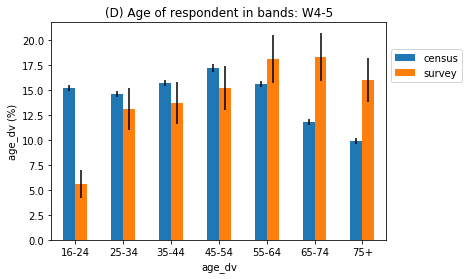

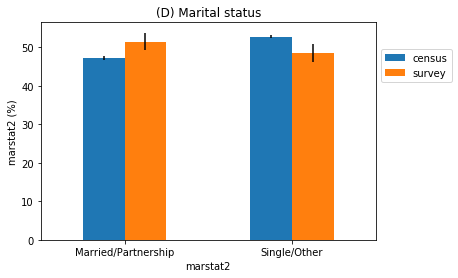

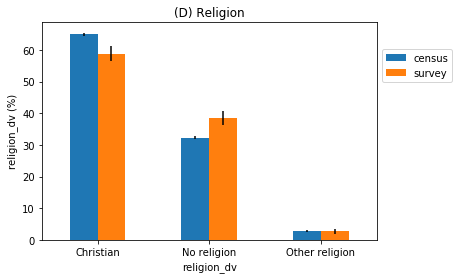

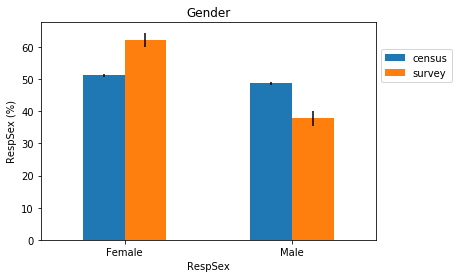

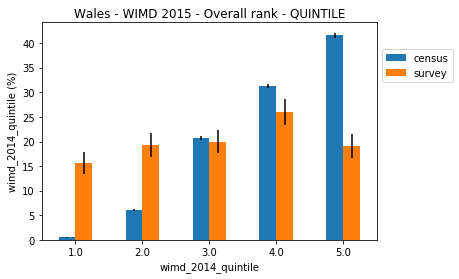

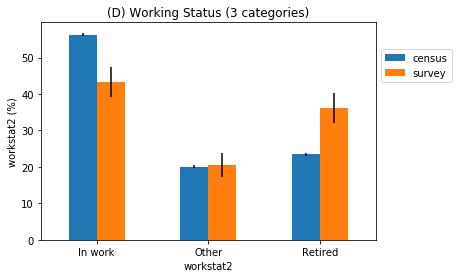

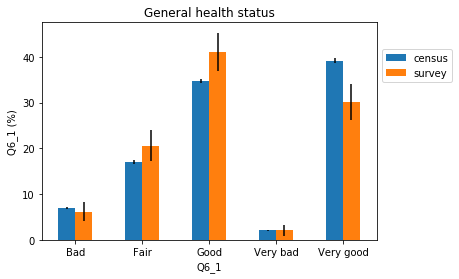

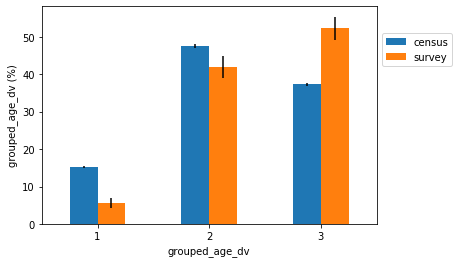

In [117]:
# Plotting demographic variables survey vs census within a for loop
# Individual .png files are saved within the same folder this notebook is saved in


for demographic_variable in demographic_variables:
    
    temp = demographics_survey_and_census.copy()
    
    # Group according to the features of interest and calculate the % of answer types for the main target feature
    temp = temp.groupby(['source', demographic_variable])[demographic_variable].agg(['count'])
    temp['total'] = temp.groupby('source')['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[demographic_variable + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp['abs_err'] = temp[demographic_variable + ' (%)'] - temp['CI_perc_lower']
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    temp

    # Recode the answers of those variables we want to use to stratify the population
    answers_to_rename = [demographic_variable]
    temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)
    
    errLo = temp.pivot(index=demographic_variable, columns='source', values='abs_err')
   
    g = temp.pivot(index=demographic_variable, columns='source', values=demographic_variable+' (%)')\
    .plot(kind='bar', yerr=errLo)
    plt.xticks(rotation=0)
    plt.ylabel(demographic_variable + ' (%)')
    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    g.set(title = questions_dict.get(demographic_variable))
    plt.show()

   # fig = g.get_figure()
   # fig.savefig('survey_vs_census_' + demographic_variable + '.png', dpi=200, bbox_inches='tight')
    plt.close()

In [131]:
# To plot the survey answers (wave 4 and 5 only) for subpopulation groups for specified relevant questions

waves = [4,5]
survey_subpopulation = survey_full_dataset.loc[survey_full_dataset['surveyyear'].isin(waves)]
survey_subpopulation[demographic_variables] = survey_subpopulation[demographic_variables].replace(answers_dict)

# Combine demographics as desired, for example:
survey_subpopulation['combined_demographics'] = [survey_subpopulation['RespSex'] + '_' +
                                                 survey_subpopulation['grouped_age_dv']]

# Define questions of interest

### ALL questions_of_interest = ['bpoison', 'Q4_26b', 'Q4_19b', 'Q4_1_5_comb', 'eatoutev', 'fdsecst', 'sanspray',
###                        'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'Q4_147'] # etc


# Select questions of interest for plotting 
questions_of_interest = ['bpoison'] # etc

for question in questions_of_interest:
    
    temp = survey_subpopulation.copy()
    
    # Group according to the features of interest and calculate the % of answer types for the main question
    
    
    
    temp = temp.groupby(['combined_demographics', question])[question].agg(['count'])
    
    
    
    temp['total'] = temp.groupby('combined_demographics')['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[question + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp['abs_err'] = temp[question + ' (%)'] - temp['CI_perc_lower']
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    temp

    # Recode the answers of the question of interest
    temp = temp.replace(answers_dict)

    
    
    
    abs_err = temp.pivot(index=question, columns='combined_demographics', values='abs_err')
   
    g = temp.pivot(index=question, columns='combined_demographics', values=question +' (%)')\
    .plot(kind='bar', yerr=abs_err)
    plt.xticks(rotation=0)
    plt.ylabel(question + ' (%)')
    plt.xlabel('')
    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    g.set(title = questions_dict.get(question))
    
    plt.show()
    # fig = g.get_figure()
    # fig.savefig('xsubpopulation_profiles_' + question + '.png', dpi=200, bbox_inches='tight')
    plt.close()

TypeError: Object with dtype category cannot perform the numpy op add

In [132]:
survey_subpopulation.head()

,SerialNo,RespSex,age_dv,bhhsize2,below6,below16,marstat2,hhdinc,workstat2,region_dv,...,FdAuthAct_MC1,FdAuthAct_MC2,FdAuthAct_MC3,FdAuthAct_MC4,FdAuthAct_MC5,FdAuthAct_MC6,FdAuthAct_MC7,FdAuthAct_MC8,FdAuthAct_MC9,grouped_age_dv
8354,400009,Female,35-44,NaN,2.0,2.0,Married/Partnership,NaN,NaN,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
8355,400012,Male,45-54,NaN,2.0,2.0,Married/Partnership,4.0,NaN,8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
8356,400013,Male,75+,NaN,2.0,2.0,Married/Partnership,4.0,NaN,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
8357,400021,Male,35-44,NaN,2.0,2.0,Single/Other,1.0,NaN,3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
8358,400022,Female,25-34,NaN,2.0,1.0,Single/Other,2.0,NaN,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2


In [ ]:


# Combine demographics as desired, for example:
survey_subpopulation['combined_demographics'] = survey_subpopulation['RespSex'] + '_' + survey_subpopulation['age_dv'] + '_' + survey_subpopulation['marstat2']

# Define questions of interest

### ALL questions_of_interest = ['bpoison', 'Q4_26b', 'Q4_19b', 'Q4_1_5_comb', 'eatoutev', 'fdsecst', 'sanspray',
###                        'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'Q4_147'] # etc


# Select questions of interest for plotting 
questions_of_interest = ['bpoison'] # etc

for question in questions_of_interest:
    
    temp = survey_subpopulation.copy()
    
    # Group according to the features of interest and calculate the % of answer types for the main question
    
    
    
    temp = temp.groupby(['combined_demographics', question])[question].agg(['count'])
    
    
    
    temp['total'] = temp.groupby('combined_demographics')['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[question + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp['abs_err'] = temp[question + ' (%)'] - temp['CI_perc_lower']
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    temp

    # Recode the answers of the question of interest
    temp = temp.replace(answers_dict)

    
    
    
    abs_err = temp.pivot(index=question, columns='combined_demographics', values='abs_err')
   
    g = temp.pivot(index=question, columns='combined_demographics', values=question +' (%)')\
    .plot(kind='bar', yerr=abs_err)
    plt.xticks(rotation=0)
    plt.ylabel(question + ' (%)')
    plt.xlabel('')
    g.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    g.set(title = questions_dict.get(question))
    
    plt.show()
    # fig = g.get_figure()
    # fig.savefig('xsubpopulation_profiles_' + question + '.png', dpi=200, bbox_inches='tight')
    plt.close()

In [ ]:
survey_subpopulation['grouped_age_dv']

In [99]:
# Remove variables which have a variance threshold less than 0.5 
# Followed this example https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
# chi-squared statistic is better suited for feature selection in categorical data
# Mishka Nemes - 19/04/2020


from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 0.5 i.e. where 95% of values are similar 
thresholder = VarianceThreshold(threshold=.1)

# Conduct variance thresholding
survey_high_variance = thresholder.fit(survey_full_dataset)

# See all the columns that have a vairance threshold higher than 0.5

high_var_cols = [column for column in survey_full_dataset.columns
                    if column not in survey_full_dataset.columns[survey_high_variance.get_support()]]


# print(len(high_var_cols))

for column in high_var_cols:
    print(column)

resfdprp
bcook3
dietary
reaccoe
reacnoc
reacglu
reaclac
reaccow
reacfpi
Q2_19
EatOut10
EatOut11
eatoutev
EatOutInfDV_Nw
EatOutInfDV_WG
EatOutInfDV_TV
EatOutInfDV_Bk
EatOutInfDV_Ad
EatOutInfDV_Oth
EatOutInfDV_None
Q2_35DV_Ca
Q2_35DV_Al
Q2_35DV_None
Q2_35DV_Oth
Q2_38DV7
resfdshp
Q3_31
Q3_34
Q3_38
Q3_310
Q3_311
Q3_312
Q3_313
Q3_1310
Q3_1311
Q4_1b1
Q4_1b6
q4_1b7
Q4_1b5
Q4_32
Q4_34
Q4_35
Q4_39
Q4_310
Q4_311
Q4_312
Q4_8a
Q4_8c5
Q4_8c6
Q4_8c7
Q4_8c8
Q4_8c9
Q4_8c9a
Q4_8c10
Q4_114
Q4_116
Q4_117
Q4_141
Q4_143
Q4_144
Q4_145
Q4_146
Q4_147
Q4_148
Q4_1410
Q4_149
q4_1411
Q4_156
q4_157
safemeat4
safemeat5
safemeat6
safemeat8
safemeat10
safemeat11
safemeat12
safemeat13
safemeat14
safedairy2
safedairy5
safedairy6
safedairy8
safedairy10
safedairy11
safedairy12
safedairy13
safedairy14
safecheese4
safecheese5
safecheese6
safecheese8
safecheese10
safecheese11
safecheese12
safecheese13
safecheese14
safeegg2
safeegg4
safeegg5
safeegg6
safeegg10
safeegg11
safeegg12
safeegg13
safeegg14
safefish4
safefish5
safef

In [ ]:
# Custom function for plotting.
# It specifies the % number on top and the count number below.
# It handles well preceding NaNs values (sns.pointplot doesn't handle this well)
def f(x,y,z, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]) + '%', xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')
    for i in range(len(x)):
        ax.annotate('n=' + str(z.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,-10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Define a wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

###################################

# Make faceted (per country) temporal line plots

pdf = PdfPages('demographics_FY_survey.pdf')
figures = []

for demographic_variable in demographic_variables:
    
    temp = survey_full_dataset[demographic_variables + ['country_dv','region_dv', 'surveyyear']]

    # Group according to the features of interest and calculate the % of answer types for the main target feature
    temp = temp.groupby(['country_dv','surveyyear', demographic_variable])[demographic_variable].agg(['count'])
    temp['total'] = temp.groupby(['country_dv','surveyyear'])['count'].transform('sum')
    lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
    temp['CI_prop_upper'] = upper
    temp['CI_prop_lower'] = lower
    temp[demographic_variable + ' (%)'] = temp['count'] / temp['total'] * 100
    temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
    temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
    temp.reset_index(inplace=True) # To 'undo' the grouping
    temp = temp.round(1)
    
    # Recode the answers of those variables we want to use to stratify the population
    answers_to_rename = ['country_dv', demographic_variable, 'surveyyear']
    temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)

    # Plot features of interest from the created 'temp' subset
    g = sns.FacetGrid(temp, col='country_dv', hue=demographic_variable, height=4, aspect=1) 
    g.map(errorbar, 'surveyyear', demographic_variable + ' (%)', 'CI_perc_lower', 'CI_perc_upper')
    g = (g.map(f, 'surveyyear', demographic_variable + ' (%)', 'count')
         .add_legend())
    plt.xlim(2009, 2019)
    g.set_titles('{col_name}', pad = 25)
    plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True, labelleft=True)
    plt.figtext(.5,.9, questions_dict.get(demographic_variable), fontsize=12, ha='center')
    
    figures += [g.fig]

for figure in figures:
    pdf.savefig(figure)
pdf.close()